# Generate Plots for Negative Controls
### Setup

In [1]:
from __future__ import division

import os
from collections import defaultdict
from cStringIO import StringIO
from json import dumps, load
from itertools import product
from collections import Counter

from numpy import array
from pymongo import MongoClient
from cogent.parse.fasta import MinimalFastaParser
from cogent.core.usage import BaseUsage
from IPython.display import Markdown, display, Image
from pandas import DataFrame
from rpy2.robjects import r, FloatVector, DataFrame as rDataFrame
from rpy2.robjects.packages import importr
quantreg = importr('quantreg')

from outliers import qcrop_facet_grid
from codon.ml import get_genetic_code

In [2]:
%load_ext rpy2.ipython
%R require(ggplot2)

/Users/ben/.virtualenvs/codon/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

In [3]:
try:
    os.mkdir('controls')
except OSError:
    pass

### Utility

In [4]:
def get_blacklist():
    with open('blacklist.json') as bl:
        return load(bl)

def get_omegas(collection):
    omegas = defaultdict(dict)
    bl = get_blacklist()
    for doc in collection.find({'_id': {'$nin': bl}}):
        for taxon, omega in doc['lf']['params']['omega'].items():
            omegas[taxon][doc['_id']] = omega['bin0']
    return omegas

def get_points(gcs, collection):
    omegas = get_omegas(collection)
    points = []
    for taxon in gcs:
        for _id in gcs[taxon]:
            x = gcs[taxon][_id]
            y = omegas[taxon][_id]
            points.append((x, y, taxon, collection.name))
    return points

def print_logs(log,  level='INFO'):
    printmd('##### ' + log.name)
    for d in log.find({'level':level}):
        printmd(dumps(d['message']))
        
def printmd(string):
    ''' thanks http://stackoverflow.com/questions/32026727/format-output-of-code-cell-with-markdown '''
    display(Markdown(string))

In [5]:
%%R
get_ggplot <- function(df)
{  
    df$row <- factor(df$row, levels=c('GNC', 'CNFGTR', 'Y98'))
    ggplot(df, aes(x,y)) +
        geom_point(aes(xcrop, ycrop), alpha=0.5, size=0.5) +
        xlab('GC content') +
        ylab(expression(omega)) +
        stat_quantile(colour="white", size=1.5, alpha=0.5) +
        stat_quantile(colour="black") +
        facet_grid(column ~ row, space="free", scale="free", labeller=label_parsed)
}

### Load Data

In [6]:
client = MongoClient()

In [7]:
cols = ['GNC', 'Y98', 'CNFGTR']
for col in ['data'] + cols:
    print_logs(getattr(client.introns, col + '.log'))

##### data.log

{"input_directory": "/short/xe9/bdk248/data/human_macaque_marmoset_introns/data/introns", "log_level": "DEBUG", "output_collection": "introns.data", "tree_file": "../config/introns.nwk", "db_host": "r2081", "aln_length": 1500, "log_name": "log", "codon_position": -1}

{"mong": "0.0.10-dev", "cogent": "1.5.3-dev", "masterslave": "0.0.10-dev", "consume": "0.0.5-dev", "monglog": "0.0.1-dev"}

##### GNC.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/GNC_no_stop.json", "input_collection": "introns.data", "output_collection": "introns.GNC", "output_collections_file": null, "output_collections": ["introns.GNC"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "GNC", "gc": "FFLLSSSSYYZOCCUWLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG"}, "log_name": "log", "input_collections": ["introns.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### Y98.log

{"function": "ml.ml", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/Y98_no_stop.json", "input_collection": "introns.data", "output_collection": "introns.Y98", "output_collections_file": null, "output_collections": ["introns.Y98"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "Y98", "gc": "FFLLSSSSYYZOCCUWLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG"}, "log_name": "log", "input_collections": ["introns.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### CNFGTR.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/CNFGTR_no_stop.json", "input_collection": "introns.data", "output_collection": "introns.CNFGTR", "output_collections_file": null, "output_collections": ["introns.CNFGTR"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "CNFGTR", "gc": "FFLLSSSSYYZOCCUWLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG"}, "log_name": "log", "input_collections": ["introns.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

{"function": "ml.ml", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/CNFGTR_no_stop.json", "input_collection": "introns.data", "output_collection": "introns.CNFGTR", "output_collections_file": null, "output_collections": ["introns.CNFGTR"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "CNFGTR", "gc": "FFLLSSSSYYZOCCUWLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG"}, "log_name": "log", "input_collections": ["introns.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

In [8]:
gcs = defaultdict(dict)
bl = get_blacklist()
for i, doc in enumerate(client.introns.data.find({'_id': {'$nin': bl}})):
    if i % 1000 == 0:
        print 'done', i
    buf = StringIO(doc['aln'].encode('utf-8'))
    aln = MinimalFastaParser(buf)
    for taxon, seq in aln:
        gcs[taxon][doc['_id']] = sum(c in 'GC' for c in seq)/len(seq)

done 0
done 1000
done 2000
done 3000
done 4000
done 5000
done 6000
done 7000
done 8000
done 9000
done 10000


In [9]:
points = []
for col in cols:
    printmd('#### ' + col)
    new_points = get_points(gcs, getattr(client.introns, col))
    print len(new_points)/3, 'points'
    points += new_points
cropped_points = zip(*qcrop_facet_grid(points))
df = dict(zip(('x', 'y', 'column', 'row', 'xcrop', 'ycrop'), cropped_points))
df = DataFrame(df)

#### GNC

10907.0 points


#### Y98

10907.0 points


#### CNFGTR

10907.0 points


### Generate the Plots

/Users/ben/.virtualenvs/codon/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Smoothing formula not specified. Using: y ~ x

  warnings.warn(x, RRuntimeWarning)


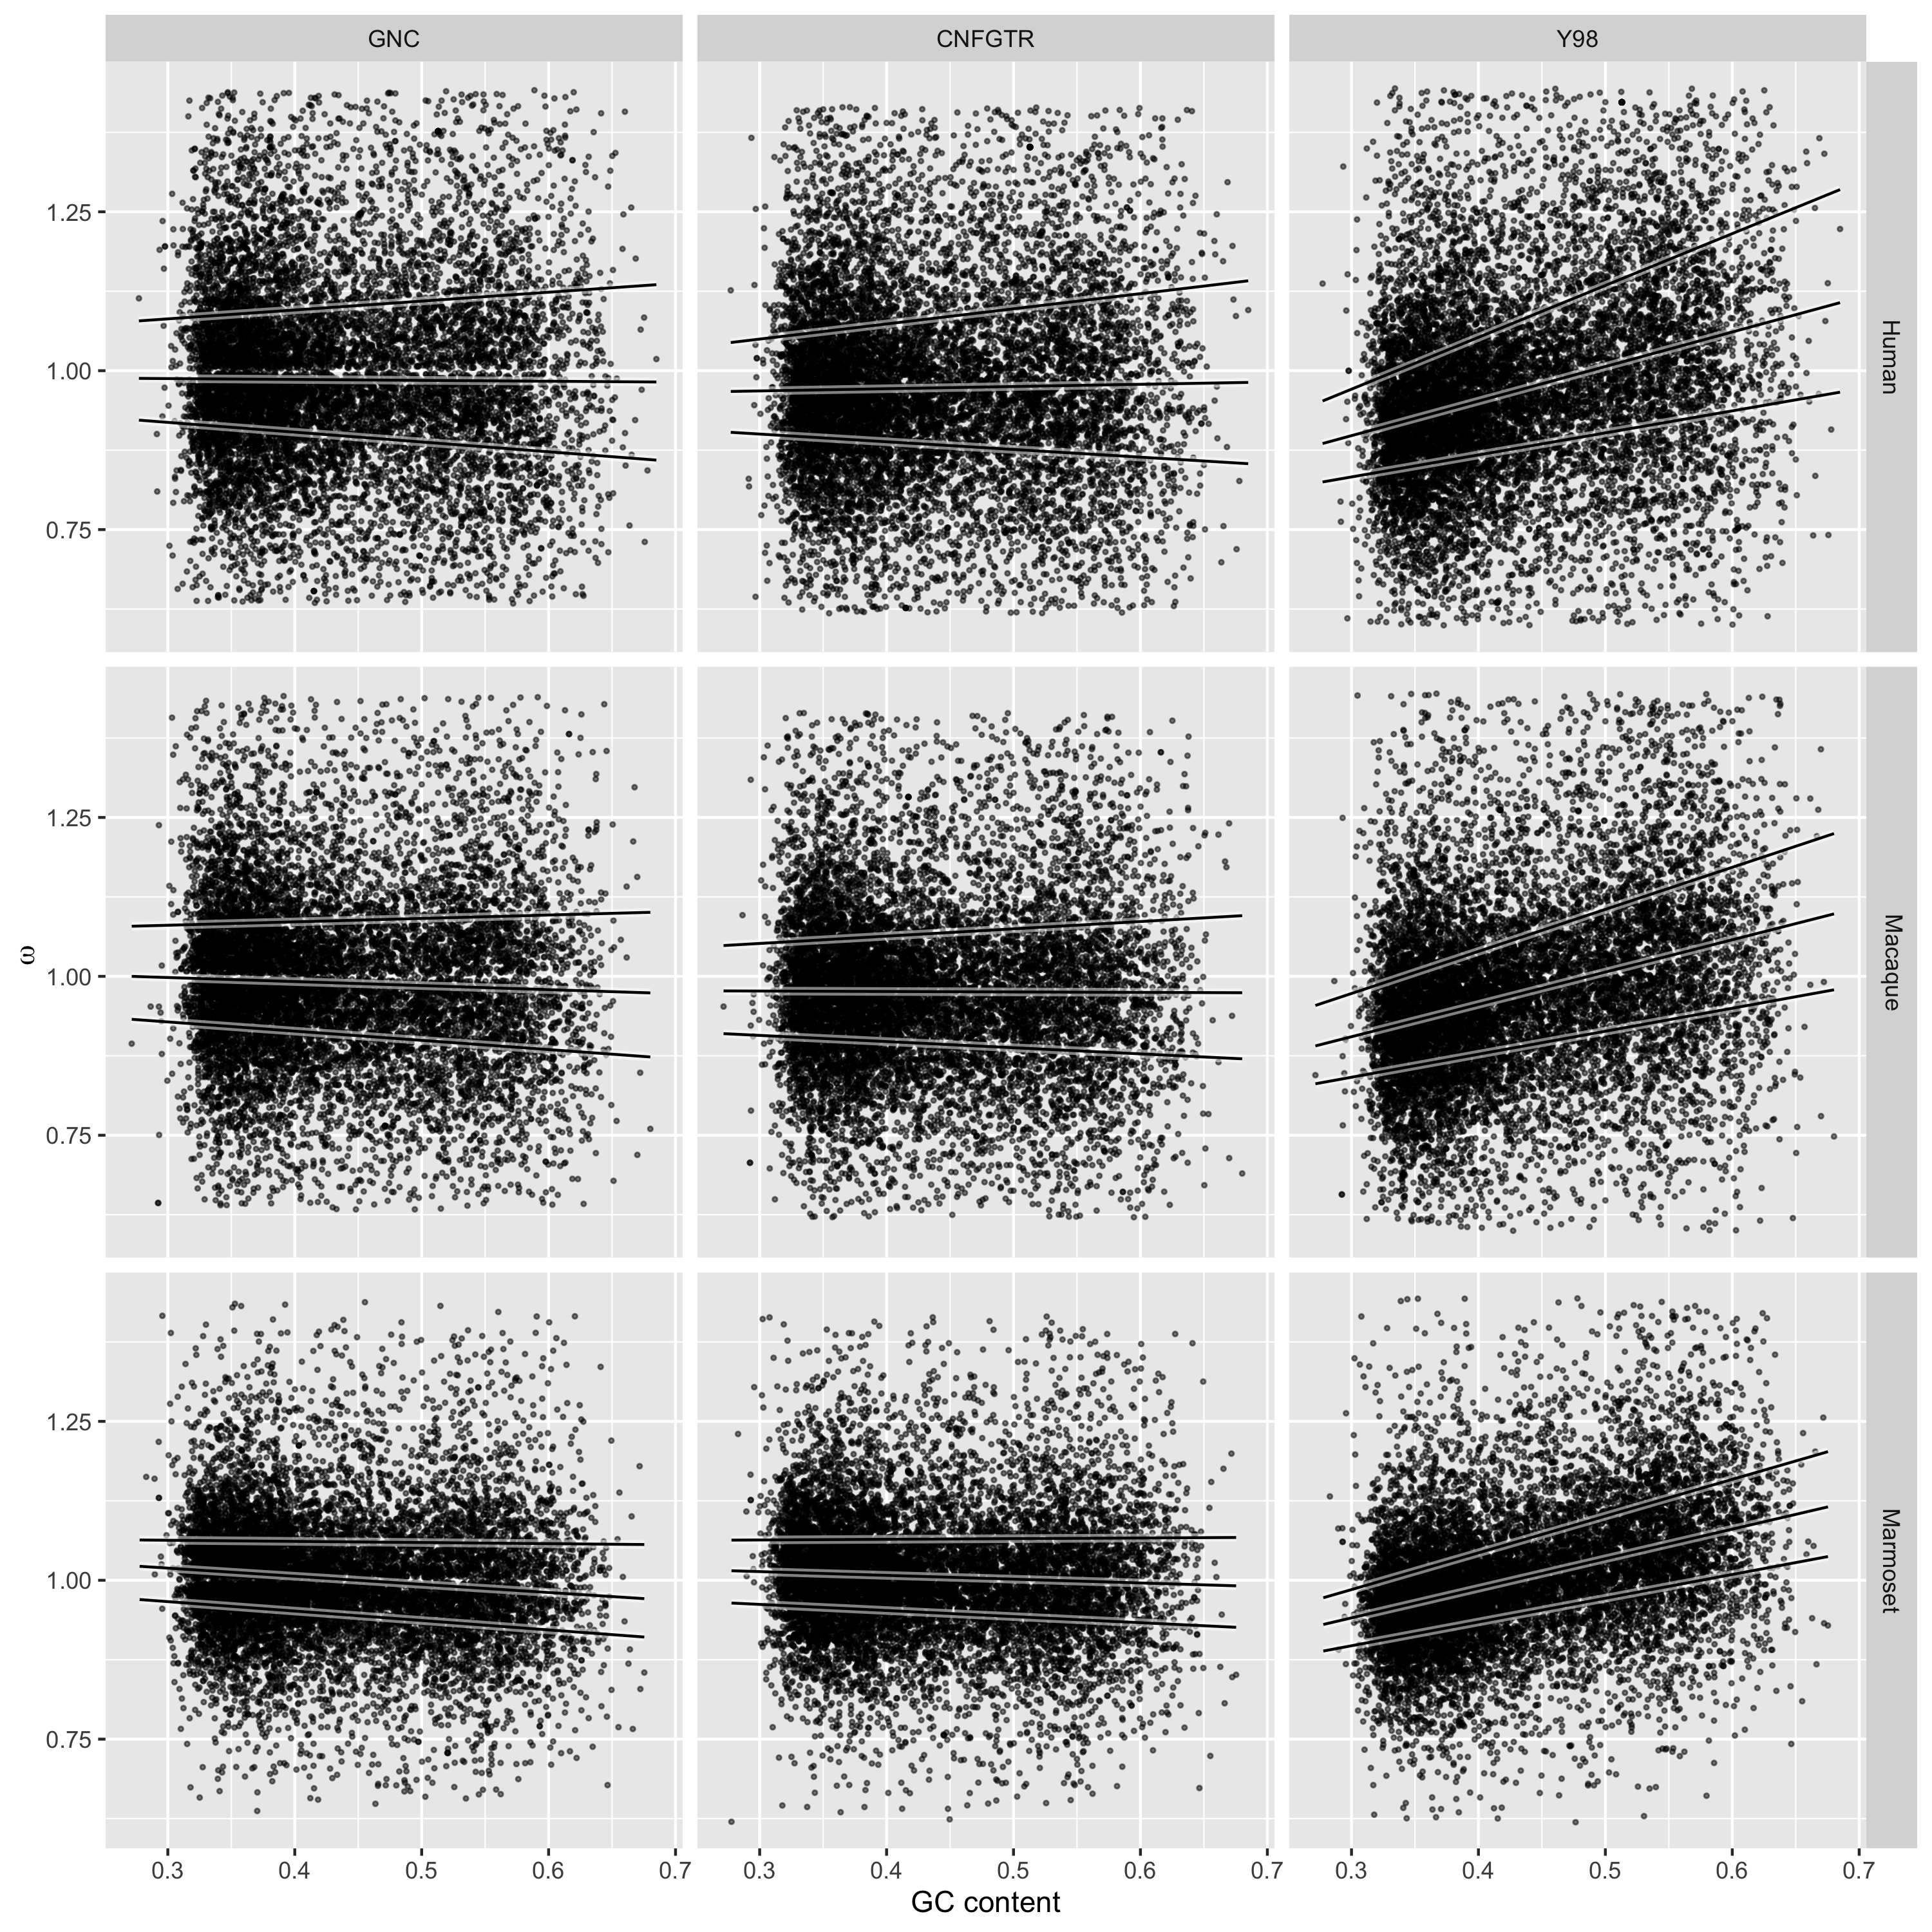

In [10]:
name = os.path.join('controls', 'introns.png')
%R -i df gg <- get_ggplot(df)
%R -i name ggsave(name, gg, width=10, height=10)
display(Image(name))

In [11]:
stats = defaultdict(list)
branches = list(set(df['column']))
for branch in branches:
    for model in set(df['row']):
        x = list(df[df['column']==branch][df['row']==model]['x'])
        y = list(df[df['column']==branch][df['row']==model]['y'])
        stats[model + ' median'].append(r.quantile(FloatVector(y))[2])
        qdf = rDataFrame({'x':FloatVector(x), 'y':FloatVector(y)})
        rq = quantreg.rq('y ~ x', qdf, tau=FloatVector((0.5,)))
        stats[model + ' median slope'].append(array(rq.rx2('coefficients'))[1])
columns = [m+' median' for m in ['GNC', 'CNFGTR', 'Y98']]
columns += [m+' median slope' for m in ['GNC', 'CNFGTR', 'Y98']]
odf = DataFrame(stats,index=branches,columns=columns)
print odf


/Users/ben/.virtualenvs/codon/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


          GNC median  CNFGTR median  Y98 median  GNC median slope  \
Marmoset    1.004565       1.005703    0.997998         -0.127920   
Macaque     0.989677       0.975956    0.969697         -0.063614   
Human       0.985884       0.972815    0.965494         -0.013885   

          CNFGTR median slope  Y98 median slope  
Marmoset            -0.059602          0.465383  
Macaque             -0.006976          0.508410  
Human                0.034760          0.543639  


In [12]:
print odf.to_latex(float_format=lambda a: "%.3f" % a)

\begin{tabular}{lrrrrrr}
\toprule
{} &  GNC median &  CNFGTR median &  Y98 median &  GNC median slope &  CNFGTR median slope &  Y98 median slope \\
\midrule
Marmoset &       1.005 &          1.006 &       0.998 &            -0.128 &               -0.060 &             0.465 \\
Macaque  &       0.990 &          0.976 &       0.970 &            -0.064 &               -0.007 &             0.508 \\
Human    &       0.986 &          0.973 &       0.965 &            -0.014 &                0.035 &             0.544 \\
\bottomrule
\end{tabular}



In [13]:
code = get_genetic_code(None)

printmd('#### With Stop Codons')
tally = Counter()
for f, t in product(*[code.Codons.keys()]*2):
    differences = [(a, b) for a, b in zip(f, t) if a != b]
    if len(differences) != 1:
        continue
    a, b = differences.pop()
    if code.Codons[f] == code.Codons[t]:
        tally['syn'] += 1
        if a in 'AT' and b in 'GC':
            tally['syn_inc_GC'] += 1
    else:
        tally['nonsyn'] += 1
        if a in 'AT' and b in 'GC':
            tally['nonsyn_inc_GC'] += 1
print 'Synonymous increase GC', tally['syn_inc_GC'] / tally['syn']
print 'Non-synonymous increase GC', tally['nonsyn_inc_GC'] / tally['nonsyn']

printmd('#### Standard Genetic Code')
tally = Counter()
for f, t in product(*[code.Codons.keys()]*2):
    if code.Codons[f] == '*' or code.Codons[t] == '*':
        continue
    differences = [(a, b) for a, b in zip(f, t) if a != b]
    if len(differences) != 1:
        continue
    a, b = differences.pop()
    if code.Codons[f] == code.Codons[t]:
        tally['syn'] += 1
        if a in 'AT' and b in 'GC':
            tally['syn_inc_GC'] += 1
    else:
        tally['nonsyn'] += 1
        if a in 'AT' and b in 'GC':
            tally['nonsyn_inc_GC'] += 1
print 'Synonymous increase GC', tally['syn_inc_GC'] / tally['syn']
print 'Non-synonymous increase GC', tally['nonsyn_inc_GC'] / tally['nonsyn']

#### With Stop Codons

Synonymous increase GC 0.376811594203
Non-synonymous increase GC 0.319634703196


#### Standard Genetic Code

Synonymous increase GC 0.373134328358
Non-synonymous increase GC 0.321428571429
